# Prepare

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os
import sys

GOOGLE_DRIVE_PATH_AFTER_MY_DRIVE = "scatter_correction_y90"
GOOGLE_DRIVE_PATH = os.path.join("drive", "My Drive", GOOGLE_DRIVE_PATH_AFTER_MY_DRIVE)

# You should see your files in the working directory printed
print(os.listdir(GOOGLE_DRIVE_PATH))

# Add to sys so that we can import your dataset easily.
sys.path.append(GOOGLE_DRIVE_PATH)

['dataset', 'best_checkpoint.pth', 'SPECT_SC_best_checkpoint.pth', 'download', 'download_new', '.ipynb_checkpoints', 'HW_CNN_best_checkpoint.pth', 'spect_scatter_correction_y90.ipynb']


In [ ]:
# Import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import glob
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary
import tqdm
from tqdm import tqdm_notebook
import time
import torch.nn.functional as F
import math

# Define global variables
SCALE_CONSTANT = 1e6
IND_NOR = True
Nx = 128 # Size of x axis
Ny_sim = 128 # Size of y axis for SIMIND
Ny_mea = 80 # Size of y axis for measurement
N_view = 128 # Number of views
Np_60 = 60
Ny_cat = 160
plt.rcParams["figure.figsize"] = (15.0, 10.0)

In [ ]:
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Please set GPU via Edit -> Notebook Settings.")
    DEVICE = torch.device("cpu")

Good to go!


# Previous implementation (HW_CNN)

In [ ]:
class HW_CNN(torch.nn.Module):
    def __init__(self):
        super(HW_CNN, self).__init__()
        self.convA1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding='same', device=DEVICE)
        self.convA2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same', device=DEVICE)
        self.convA3 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same', device=DEVICE)

        self.convB1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding='same', device=DEVICE)
        self.convB2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same', device=DEVICE)
        self.convB3 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same', device=DEVICE)

        self.relu = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding='same', device=DEVICE)
        self.conv3 = torch.nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding='same', device=DEVICE)
        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding='same', device=DEVICE)
        self.conv5 = torch.nn.Conv2d(in_channels=32, out_channels=1, kernel_size=1, padding='same', device=DEVICE)

    def forward(self, proj_mu, spect_proj):
        proj_mu_ = self.convA1(proj_mu)
        proj_mu_ = self.relu(proj_mu_)
        proj_mu_ = self.convA2(proj_mu_)
        proj_mu_ = self.relu(proj_mu_)
        proj_mu_ = self.convA3(proj_mu_)
        proj_mu_ = self.relu(proj_mu_)

        spect_proj_ = self.convB1(spect_proj)
        spect_proj_ = self.relu(spect_proj_)
        spect_proj_ = self.convB2(spect_proj_)
        spect_proj_ = self.relu(spect_proj_)
        spect_proj_ = self.convB3(spect_proj_)
        spect_proj_ = self.relu(spect_proj_)

        out = torch.cat([spect_proj_, proj_mu_], dim=1)
        out = self.relu(self.conv2(out))
        out = self.relu(self.conv3(out))
        out = self.relu(self.conv4(out))
        out = self.relu(self.conv5(out))

        return out

In [ ]:
class SPECT_DATASET_NON_UNIF():
    def __init__(self):
        self.train_mu = None
        self.train_tot = None
        self.train_sca = None
        self.train_pri = None
        self.train_concat = None

        self.test_mu = None
        self.test_tot = None
        self.test_sca = None
        self.test_pri = None
        self.test_concat = None

        self.N_train = None
        self.N_test = None

    def load_data(self, train_file_path, test_file_path):
        train_file_names = glob.glob(train_file_path)
        test_file_names = glob.glob(test_file_path)
        self.N_train = len(train_file_names)
        self.N_test = len(test_file_names)

        self.train_mu = torch.zeros((Nx, Ny_mea, N_view, self.N_train)).to(DEVICE)  # 128* 80*128*5
        self.train_tot = torch.zeros((Nx, Ny_mea, N_view, self.N_train)).to(DEVICE) # 128* 80*128*5
        self.train_sca = torch.zeros((Nx, Ny_mea, N_view, self.N_train)).to(DEVICE) # 128* 80*128*5
        # self.train_pri = torch.zeros((Nx, Ny_sim, N_view, self.N_train)).to(DEVICE) # 128*128*128*8

        self.test_mu = torch.zeros((Nx, Ny_mea, N_view, self.N_test)).to(DEVICE)  # 128* 80*128*?
        self.test_tot = torch.zeros((Nx, Ny_mea, N_view, self.N_test)).to(DEVICE) # 128* 80*128*?
        self.test_sca = torch.zeros((Nx, Ny_mea, N_view, self.N_test)).to(DEVICE) # 128* 80*128*?
        # self.test_pri = torch.zeros((Nx, Ny_mea, N_view, self.N_test)).to(DEVICE) # 128* 80*128*6

        print("---Training data loading---")
        for i in range(self.N_train):
            train_data = sio.loadmat(train_file_names[i])
            tot = torch.from_numpy(train_data["tot"])
            sca = torch.from_numpy(train_data["sca"])
            proj_mu = torch.from_numpy(train_data["proj_mu"])
            self.train_mu[:,:,:,i] = proj_mu
            self.train_tot[:,:,:,i] = tot[:,24:104,:]
            self.train_sca[:,:,:,i] = sca[:,24:104,:]
            print(i+1, train_file_names[i])
        print()

        print("---Test data loading---")
        for i in range(self.N_test):
            test_data = sio.loadmat(test_file_names[i])
            tot = torch.from_numpy(test_data["tot"])
            sca = torch.from_numpy(test_data["sca"])
            proj_mu = torch.from_numpy(test_data["proj_mu"])
            self.test_mu[:,:,:,i] = proj_mu
            self.test_tot[:,:,:,i] = tot[:,24:104,:]
            self.test_sca[:,:,:,i] = sca[:,24:104,:]
            print(i+1, test_file_names[i])
        print()

    def print_dataset_info(self, str):
        print("---Dataset " + str + " info printing---")
        print("train_mu.shape:", self.train_mu.shape)
        print("train_tot.shape:", self.train_tot.shape)
        print("train_sca.shape:", self.train_sca.shape)

        print("test_mu.shape:", self.test_mu.shape)
        print("test_tot.shape:", self.test_tot.shape)
        print("test_sca.shape:", self.test_sca.shape)
        print()

    def scale_dataset(self):
        # Scale training/test data to make simulated and measured data consistent
        print("---Scaling dataset---")
        self.train_sca = SCALE_CONSTANT * self.train_sca / (torch.sum(self.train_tot, dim=[0,1,2])[None, None, None, :])
        self.train_tot = SCALE_CONSTANT * self.train_tot / (torch.sum(self.train_tot, dim=[0,1,2])[None, None, None, :])
        self.train_mu = self.train_mu

        self.test_sca = SCALE_CONSTANT * self.test_sca / (torch.sum(self.test_tot, dim=[0,1,2])[None, None, None, :])
        self.test_tot = SCALE_CONSTANT * self.test_tot / (torch.sum(self.test_tot, dim=[0,1,2])[None, None, None, :])
        self.test_mu = self.test_mu
        print()

    def reshape_dataset(self):
        self.train_tot = torch.reshape(self.train_tot, [Nx, Ny_mea, N_view * self.N_train])
        self.train_tot = torch.permute(self.train_tot, [2, 0, 1])[:,None,:,:] # (128*N_train, 1, 128, 80)
        self.train_sca = torch.reshape(self.train_sca, [Nx, Ny_mea, N_view * self.N_train])
        self.train_sca = torch.permute(self.train_sca, [2, 0, 1])[:,None,:,:] # (128*N_train, 1, 128, 80)
        self.train_mu = torch.reshape(self.train_mu, [Nx, Ny_mea, N_view * self.N_train])
        self.train_mu = torch.permute(self.train_mu, [2, 0, 1])[:,None,:,:] # (128*N_train, 1, 128, 80)

        self.test_tot = torch.reshape(self.test_tot, [Nx, Ny_mea, N_view * self.N_test])
        self.test_tot = torch.permute(self.test_tot, [2, 0, 1])[:,None,:,:] # (128*N_test, 1, 128, 80)
        self.test_sca = torch.reshape(self.test_sca, [Nx, Ny_mea, N_view * self.N_test])
        self.test_sca = torch.permute(self.test_sca, [2, 0, 1])[:,None,:,:] # (128*N_test, 1, 128, 80)
        self.test_mu = torch.reshape(self.test_mu, [Nx, Ny_mea, N_view * self.N_test])
        self.test_mu = torch.permute(self.test_mu, [2, 0, 1])[:,None,:,:] # (128*N_test, 1, 128, 80)

    def data_preprocess(self, train_file_path, test_file_path):
        self.load_data(train_file_path, test_file_path)
        self.print_dataset_info("(raw)")
        self.scale_dataset()
        self.reshape_dataset()
        self.print_dataset_info("(processed)")

    def plot_projection_train(self, k=9):
        plt.style.use("default")
        fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, figsize=(15, 10))
        im1 = ax1.imshow(np.transpose(self.train_sca[k,0,:,:].cpu()), cmap = 'jet', vmin = 0, vmax = torch.max(self.train_tot[k,0,:,:]))
        ax1.set_title('Scatter',fontsize = 20)

        im2 = ax2.imshow(np.transpose(self.train_tot[k,0,:,:].cpu()), cmap = 'jet', vmin = 0, vmax = torch.max(self.train_tot[k,0,:,:]))
        ax2.set_title('Total', fontsize = 20)

        im3 = ax3.imshow(np.transpose(self.train_mu[k,0,:,:].cpu()), cmap = 'jet', vmin = 0, vmax = torch.max(self.train_mu[k,0,:,:]))
        ax3.set_title('mu-map', fontsize = 20)

        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.35, 0.03, 0.3])
        fig.colorbar(im2, cax=cbar_ax)

    def plot_projection_test(self, k=80):
        plt.style.use("default")
        fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 10))
        im1 = ax1.imshow(np.transpose(self.test_sca[k,0,:,:].cpu()), cmap = 'jet', vmin = 0, vmax = torch.max(self.test_tot[k,0,:,:]))
        ax1.set_title('Scatter',fontsize = 20)

        im2 = ax2.imshow(np.transpose(self.test_tot[k,0,:,:].cpu()), cmap = 'jet', vmin = 0, vmax = torch.max(self.test_tot[k,0,:,:]))
        ax2.set_title('Total', fontsize = 20)

        im3 = ax3.imshow(np.transpose(self.test_mu[k,0,:,:].cpu()), cmap = 'jet', vmin = 0, vmax = torch.max(self.test_mu[k,0,:,:]))
        ax3.set_title('mu-map', fontsize = 20)

        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.35, 0.03, 0.3])
        fig.colorbar(im2, cax=cbar_ax)

In [ ]:
class SPECT_CNN_SC_HW():
    def __init__(self, Epoch=800, batch_size=32, learning_rate=1e-4):
        self.model = HW_CNN()
        self.num_epoch = Epoch
        self.batch_size = batch_size
        self.num_train = 640 # using 5 images for training
        self.lr = learning_rate
        self.training_loss_history = []
        self.val_loss_history = []
        self.mse_test_ls = []
        self.num_val = None # using 1 or 2 image(s) for testing

    def model_initialize(self):
        self.model = HW_CNN()
        for p in self.model.parameters():
            torch.nn.init.normal_(p,std=0.1)

    def save_checkpoint(self, state):
        best_file_path = os.path.join(GOOGLE_DRIVE_PATH, 'HW_CNN_best_checkpoint.pth')
        torch.save(state, best_file_path)

    def train(self, s):
        torch.manual_seed(2022)
        self.model_initialize() # Initialize a new model
        self.num_val = s.train_tot.size(0) - self.num_train
        train_loader = DataLoader(TensorDataset(s.train_mu[idx_train,:,:,:],
                                                s.train_tot[idx_train,:,:,:],
                                                s.train_sca[idx_train,:,:,:]),
                                  batch_size=self.batch_size, shuffle=False)

        val_loader = DataLoader(TensorDataset(s.train_mu[idx_val,:,:,:],
                                              s.train_tot[idx_val,:,:,:],
                                              s.train_sca[idx_val,:,:,:]),
                                batch_size=self.batch_size, shuffle=False)

        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

        # Clear the history
        self.training_loss_history = []
        self.val_loss_history = []

        start_time = time.time()
        best_val_loss = np.inf

        for epoch in tqdm.tqdm_notebook(range(self.num_epoch)):
            training_loss_acc = 0
            val_loss_acc = 0

            for _, training_data in enumerate(train_loader,0):
                mu_batch, tot_batch, sca_batch = training_data
                sca_pred = self.model(mu_batch, tot_batch)
                optimizer.zero_grad()
                loss = torch.nn.functional.mse_loss(sca_pred, sca_batch)
                loss.backward()
                optimizer.step()
                training_loss_acc += loss.detach().item()

            self.training_loss_history.append(math.sqrt(training_loss_acc) / self.num_train)

            with torch.no_grad():
                for _, val_data in enumerate(val_loader,0):
                    mu_batch_val, tot_batch_val, sca_batch_val = val_data
                    sca_pred_val = self.model(mu_batch_val, tot_batch_val)
                    loss_val = torch.nn.functional.mse_loss(sca_pred_val, sca_batch_val)
                    val_loss_acc += loss_val.item()

            self.val_loss_history.append(math.sqrt(val_loss_acc) / self.num_val)

            print("Epoch {}, training loss {:3f}, val loss {:3f}".format(epoch+1, self.training_loss_history[-1], self.val_loss_history[-1]), end=' ')

            if self.val_loss_history[-1] < best_val_loss:
                # save this model!
                print(" Oh! Best validation performance! Save the current model!")
                self.save_checkpoint(self.model.state_dict())
                best_val_loss = self.val_loss_history[-1]
            else:
                print()

        end_time = time.time()
        total_time = end_time - start_time
        print("Total time used: {:3f} s".format(total_time))

    def save_model(self, isUniform:bool):
        if isUniform:
            save_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'SPECT_SC_CNN_UNIFORM_HW.pth')
            torch.save(self.model.state_dict(), save_PATH)
        else:
            save_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'SPECT_SC_CNN_NON_UNIFORM_HW.pth')
            torch.save(self.model.state_dict(), save_PATH)

    def load_model(self, file_name:str):
        if file_name in os.listdir(GOOGLE_DRIVE_PATH):
            load_PATH = os.path.join(GOOGLE_DRIVE_PATH, file_name)
            self.model.load_state_dict(torch.load(load_PATH))
        else:
            print("Model not found!")

    '''
    def plot_learning_curve(self, num_crop=15):
        # Crop the first several huge loss for better view
        N_step = int(self.num_train / self.num_val)
        training_loss_history_crop = self.training_loss_history[0:-1:N_step][num_crop:]
        val_loss_history_crop = self.val_loss_history[0:-1][num_crop:]
        x_t = range(len(training_loss_history_crop))
        x_v = range(len(val_loss_history_crop))

        plt.plot(x_t, training_loss_history_crop, label="training loss")
        plt.plot(x_v, val_loss_history_crop, label="validation loss")
        plt.legend(['Training_loss', 'Validation_loss'])

        # plt.close()
    '''

    def run_test(self, s):
        '''
        Return predicted scatter for the whole test dataset.
        '''
        test_loader = DataLoader(TensorDataset(s.test_mu, s.test_tot, s.test_sca),
                                 batch_size=self.batch_size)

        # A dummy initializer, to be removed in the end
        sca_pred_CNN = torch.ones(1,1,128,80).to(DEVICE)

        with torch.no_grad():
            for _, test_data in enumerate(test_loader,0):
                mu_batch, tot_batch, sca_batch = test_data
                sca_pred = self.model(mu_batch, tot_batch) # B * 1 * 128 * 80
                sca_pred_CNN = torch.cat([sca_pred_CNN, sca_pred], dim=0)

                mse_test = torch.nn.functional.mse_loss(sca_pred, sca_batch)
                self.mse_test_ls.append(mse_test.item())

            # (K*B+1) * 1 * 128 * 80 -> (K*B) * 1 * 128 * 80 i.e. N_test * 1 * 128 * 80
            sca_pred_CNN = sca_pred_CNN[1:,:,:,:]
        return sca_pred_CNN

    def plot_projection_test(self, x:torch.Tensor(), s, k:int):
        """
        Plots scatter patterns of the certain TEST case.

            Parameters:
                x (torch.Tensor()): The reshaped output of the CNN. (2D)
                s (SPECT_DATASET()): The object that contains the original data.
                k (int): The number of the test data slice.
        """
        plt.style.use("default")
        fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 10))
        im1 = ax1.imshow(np.transpose(x.cpu()), cmap='jet', vmin=0, vmax=torch.max(s.test_tot[k,0,:,:]))
        ax1.set_title('CNN Scatter',fontsize=20)

        im2 = ax2.imshow(np.transpose(s.test_sca[k,0,:,:].cpu()), cmap='jet', vmin=0, vmax=torch.max(s.test_tot[k,0,:,:]))
        ax2.set_title('True Scatter', fontsize=20)

        im3 = ax3.imshow(np.transpose(s.test_tot[k,0,:,:].cpu()), cmap='jet', vmin=0, vmax=torch.max(s.test_tot[k,0,:,:]))
        ax3.set_title('Total', fontsize=20)

        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.35, 0.03, 0.3])
        fig.colorbar(im1, cax=cbar_ax)

    def test_and_plot_k(self, s, k:int):
        """
        Predict the CNN scatter with the trained model and make a plot.

            Parameters:
                s (SPECT_DATASET()): The object that contains the original data.
                k (int): The number of the test data slice.
        """
        with torch.no_grad():
            test_img = self.model(s.test_mu[k,:,:,:][None,:,:,:], s.test_tot[k,:,:,:][None,:,:,:])

        self.plot_projection_test(test_img[0,0,:,:], s, k)


In [ ]:
train_file_path = os.path.join(GOOGLE_DRIVE_PATH, 'dataset/train/*.mat')
test_file_path = os.path.join(GOOGLE_DRIVE_PATH, 'dataset/test_real_patient_2/*.mat')

s_0 = SPECT_DATASET_NON_UNIF()
s_0.data_preprocess(train_file_path, test_file_path)

spect_cnn_sc_hw = SPECT_CNN_SC_HW()

In [ ]:
# spect_cnn_sc_hw = SPECT_CNN_SC_HW()
# spect_cnn_sc_hw.train(s_0)

In [ ]:
# train_ls = spect_cnn_sc_hw.training_loss_history
# val_ls = spect_cnn_sc_hw.val_loss_history
# plt.plot(range(len(train_ls)), train_ls)
# plt.plot(range(len(train_ls)), val_ls)

In [ ]:
# s_1 = SPECT_CNN_SC_HW()
# s_1.load_model('best_checkpoint.pth')

# Our implementation

In [ ]:
class SPECT_SC_Net(torch.nn.Module):
    '''
    1. Concatenate the spect_proj and proj_mu into a single tensor with two channels
    and treat as one input.
    2. Design an Encoder-Decoder scheme (Keep the dimensions).
        Channel:
            3 -> 32 -> 64 -> 128 -> 256 -> 128 -> 64 -> 32 -> 1
    '''
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding='same', device=DEVICE)
        self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same', device=DEVICE)
        self.conv3 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same', device=DEVICE)
        self.conv4 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding='same', device=DEVICE)
        self.conv5 = torch.nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding='same', device=DEVICE)
        self.conv6 = torch.nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding='same', device=DEVICE)
        self.conv7 = torch.nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding='same', device=DEVICE)
        self.conv8 = torch.nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding='same', device=DEVICE)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.relu(self.conv7(x))
        out = self.relu(self.conv8(x))
        return out

In [ ]:
class SPECT_SC:
    def __init__(self):

        # For the model initialization
        self.model = SPECT_SC_Net()

        # For the data
        self.train_mu = None
        self.train_tot = None
        self.train_sca = None

        self.test_mu = None
        self.test_tot = None
        self.test_sca = None

        self.train_inputs_1 = None
        self.test_inputs_1 = None

        self.N_train = None # 6
        self.N_test = None # ?

        # For the networks
        # self.model = None
        self.num_epoch = 800
        self.batch_size = 32
        self.num_train = 640 # 5 out 6 images for training, 1 for validation
        self.lr = 6e-5
        self.training_loss_history = []
        self.val_loss_history = []
        self.mse_test_ls = []
        self.num_val = None

    def load_data(self, train_file_path, test_file_path):
        train_file_names = glob.glob(train_file_path)
        test_file_names = glob.glob(test_file_path)

        self.N_train = len(train_file_names)
        self.N_test = len(test_file_names)

        self.train_mu = torch.zeros((Nx, Ny_mea, N_view, self.N_train)).to(DEVICE)  # 128* 80*128*5
        self.train_tot = torch.zeros((Nx, Ny_mea, N_view, self.N_train)).to(DEVICE) # 128*128*128*5
        self.train_sca = torch.zeros((Nx, Ny_mea, N_view, self.N_train)).to(DEVICE) # 128*128*128*5

        self.test_mu = torch.zeros((Nx, Ny_mea, N_view, self.N_test)).to(DEVICE)  # 128* 80*128*?
        self.test_tot = torch.zeros((Nx, Ny_mea, N_view, self.N_test)).to(DEVICE) # 128*128*128*?
        self.test_sca = torch.zeros((Nx, Ny_mea, N_view, self.N_test)).to(DEVICE) # 128*128*128*?

        print("---Training data loading---")
        for i in range(self.N_train):
            train_data = sio.loadmat(train_file_names[i])
            tot = torch.from_numpy(train_data["tot"])
            sca = torch.from_numpy(train_data["sca"])
            proj_mu = torch.from_numpy(train_data["proj_mu"])
            self.train_mu[:,:,:,i] = proj_mu
            self.train_tot[:,:,:,i] = tot[:,24:104,:]
            self.train_sca[:,:,:,i] = sca[:,24:104,:]
            print(i+1, train_file_names[i])
        print()

        print("---Test data loading---")
        for i in range(self.N_test):
            test_data = sio.loadmat(test_file_names[i])
            tot = torch.from_numpy(test_data["tot"])
            sca = torch.from_numpy(test_data["sca"])
            proj_mu = torch.from_numpy(test_data["proj_mu"])
            self.test_mu[:,:,:,i] = proj_mu
            self.test_tot[:,:,:,i] = tot[:,24:104,:]
            self.test_sca[:,:,:,i] = sca[:,24:104,:]
            print(i+1, test_file_names[i])
        print()

    def print_dataset_info(self, str):
        print("---Dataset " + str + " info printing---")
        print("train_mu.shape:", self.train_mu.shape)
        print("train_tot.shape:", self.train_tot.shape)
        print("train_sca.shape:", self.train_sca.shape)

        print("test_mu.shape:", self.test_mu.shape)
        print("test_tot.shape:", self.test_tot.shape)
        print("test_sca.shape:", self.test_sca.shape)

        if self.train_inputs_1 is not None:
            print("train_inputs.shape:", self.train_inputs_1.shape)
            print("test_inputs.shape:", self.test_inputs_1.shape)
        print()

    def scale_dataset(self):
        # Scale training/test data to make simulated and measured data consistent
        print("---Scaling dataset---")
        self.train_sca = SCALE_CONSTANT * self.train_sca / (torch.sum(self.train_tot, dim=[0,1,2])[None, None, None, :])
        self.train_tot = SCALE_CONSTANT * self.train_tot / (torch.sum(self.train_tot, dim=[0,1,2])[None, None, None, :])
        self.train_mu = self.train_mu

        self.test_sca = SCALE_CONSTANT * self.test_sca / (torch.sum(self.test_tot, dim=[0,1,2])[None, None, None, :])
        self.test_tot = SCALE_CONSTANT * self.test_tot / (torch.sum(self.test_tot, dim=[0,1,2])[None, None, None, :])
        self.test_mu = self.test_mu
        print()

    def reshape_dataset(self):
        # self.train_tot = torch.reshape(self.train_tot, [Nx, Ny_mea, N_view * self.N_train])
        self.train_tot = torch.cat([self.train_tot[:,:,:,nv] for nv in range(self.N_train)], dim=2)
        self.train_tot = torch.permute(self.train_tot, [2, 0, 1])[:,None,:,:] # (128*N_train, 1, 128, 80)
        self.train_sca = torch.cat([self.train_sca[:,:,:,nv] for nv in range(self.N_train)], dim=2)
        self.train_sca = torch.permute(self.train_sca, [2, 0, 1])[:,None,:,:] # (128*N_train, 1, 128, 80)
        self.train_mu = torch.cat([self.train_mu[:,:,:,nv] for nv in range(self.N_train)], dim=2)
        self.train_mu = torch.permute(self.train_mu, [2, 0, 1])[:,None,:,:] # (128*N_train, 1, 128, 80)

        self.test_tot = torch.cat([self.test_tot[:,:,:,nv] for nv in range(self.N_test)], dim=2)
        self.test_tot = torch.permute(self.test_tot, [2, 0, 1])[:,None,:,:] # (128*N_test, 1, 128, 80)
        self.test_sca = torch.cat([self.test_sca[:,:,:,nv] for nv in range(self.N_test)], dim=2)
        self.test_sca = torch.permute(self.test_sca, [2, 0, 1])[:,None,:,:] # (128*N_test, 1, 128, 80)
        self.test_mu = torch.cat([self.test_mu[:,:,:,nv] for nv in range(self.N_test)], dim=2)
        self.test_mu = torch.permute(self.test_mu, [2, 0, 1])[:,None,:,:] # (128*N_test, 1, 128, 80)

        train_tot_2 = torch.zeros_like(self.train_tot)
        test_tot_2 = torch.zeros_like(self.test_tot)

        for n in range(self.N_train):
            low_idx = n * N_view # 0, 128, 256, ...
            train_tot_2[(64+low_idx):(128+low_idx),:,:,:] = self.train_tot[(0+low_idx):(64+low_idx),:,:,:]
            train_tot_2[(0+low_idx):(64+low_idx),:,:,:] = self.train_tot[(64+low_idx):(128+low_idx),:,:,:]
            # train_tot_2.size() : (896, 1, 128, 80)
        for n in range(self.N_test):
            low_idx = n * N_view # 0
            test_tot_2[(64+low_idx):(128+low_idx),:,:,:] = self.test_tot[(0+low_idx):(64+low_idx),:,:,:]
            test_tot_2[(0+low_idx):(64+low_idx),:,:,:] = self.test_tot[(64+low_idx):(128+low_idx),:,:,:]

        # Flip the image by the middle axis
        for n in range(self.N_train * N_view): # 896
            # flip_image(train_tot_2[n,0,:,:])
            for m in range(64):
                tmp = train_tot_2[n,0,m,:].clone()
                train_tot_2[n,0,m,:] = train_tot_2[n,0,127-m,:]
                train_tot_2[n,0,127-m,:] = tmp

        for n in range(self.N_test * N_view):
            for m in range(64):
                tmp = test_tot_2[n,0,m,:].clone()
                test_tot_2[n,0,m,:] = test_tot_2[n,0,127-m,:]
                test_tot_2[n,0,127-m,:] = tmp

        self.train_inputs_1 = torch.squeeze(torch.stack([self.train_tot, train_tot_2, self.train_mu], dim=1)) # (896, 3, 128, 80)
        self.test_inputs_1 = torch.squeeze(torch.stack([self.test_tot, test_tot_2, self.test_mu], dim=1)) # (128, 3, 128, 80)

    def data_preprocess(self, train_file_path, test_file_path):
        self.load_data(train_file_path, test_file_path)
        self.print_dataset_info("(raw)")
        self.scale_dataset()
        self.reshape_dataset()
        self.print_dataset_info("(processed)")

    def plot_projection_train_data(self, k=9):
        plt.style.use("default")
        fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, figsize=(15, 10))
        im1 = ax1.imshow(np.transpose(self.train_sca[k,0,:,:].cpu()), cmap = 'jet', vmin = 0, vmax = torch.max(self.train_tot[k,0,:,:]))
        ax1.set_title('Scatter',fontsize = 20)

        im2 = ax2.imshow(np.transpose(self.train_tot[k,0,:,:].cpu()), cmap = 'jet', vmin = 0, vmax = torch.max(self.train_tot[k,0,:,:]))
        ax2.set_title('Total', fontsize = 20)

        im3 = ax3.imshow(np.transpose(self.train_mu[k,0,:,:].cpu()), cmap = 'jet', vmin = 0, vmax = torch.max(self.train_mu[k,0,:,:]))
        ax3.set_title('mu-map', fontsize = 20)

        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.35, 0.03, 0.3])
        fig.colorbar(im2, cax=cbar_ax)

    def plot_projection_test_data(self, k=80):
        plt.style.use("default")
        fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 10))
        im1 = ax1.imshow(np.transpose(self.test_sca[k,0,:,:].cpu()), cmap = 'jet', vmin = 0, vmax = torch.max(self.test_tot[k,0,:,:]))
        ax1.set_title('Scatter',fontsize = 20)

        im2 = ax2.imshow(np.transpose(self.test_tot[k,0,:,:].cpu()), cmap = 'jet', vmin = 0, vmax = torch.max(self.test_tot[k,0,:,:]))
        ax2.set_title('Total', fontsize = 20)

        im3 = ax3.imshow(np.transpose(self.test_mu[k,0,:,:].cpu()), cmap = 'jet', vmin = 0, vmax = torch.max(self.test_mu[k,0,:,:]))
        ax3.set_title('mu-map', fontsize = 20)

        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.35, 0.03, 0.3])
        fig.colorbar(im2, cax=cbar_ax)

    def save_checkpoint(self, state):
        best_file_path = os.path.join(GOOGLE_DRIVE_PATH, 'SPECT_SC_best_checkpoint.pth')
        torch.save(state, best_file_path)

    def model_initialize(self):
        self.model = SPECT_SC_Net()
        for p in self.model.parameters():
            torch.nn.init.normal_(p,std=0.001)

    def train(self):
        torch.manual_seed(2022)
        self.model_initialize() # Initialize a new model

        self.num_val = self.train_tot.size(0) - self.num_train
        train_loader = DataLoader(TensorDataset(self.train_inputs_1[idx_train,:,:,:],
                                                self.train_sca[idx_train,:,:,:]),
                                  batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(self.train_inputs_1[idx_val,:,:,:],
                                              self.train_sca[idx_val,:,:,:]),
                                  batch_size=self.batch_size, shuffle=True)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.training_loss_history = []
        self.val_loss_history = []

        start_time = time.time()
        best_val_loss = np.inf

        for epoch in tqdm.tqdm_notebook(range(self.num_epoch)):
            training_loss_acc = 0
            val_loss_acc = 0

            for _, training_data in enumerate(train_loader, 0):
                inputs_batch, sca_batch = training_data
                sca_pred = self.model(inputs_batch)

                optimizer.zero_grad()

                loss = F.mse_loss(sca_pred, sca_batch)
                loss.backward()
                optimizer.step()
                training_loss_acc += loss.detach().item()

            self.training_loss_history.append(math.sqrt(training_loss_acc) / self.num_train)

            with torch.no_grad():
                for _,val_data in enumerate(val_loader, 0):
                    inputs_batch_val, sca_batch_val = val_data
                    sca_pred_val = self.model(inputs_batch_val)
                    loss_val = F.mse_loss(sca_pred_val, sca_batch_val)
                    val_loss_acc += loss_val.item()

            self.val_loss_history.append(math.sqrt(val_loss_acc) / self.num_val)

            print("Epoch {}, training loss {:3f}, val loss {:3f}".format(epoch+1, self.training_loss_history[-1], self.val_loss_history[-1]), end=' ')

            if self.val_loss_history[-1] < best_val_loss:
                # save this model!
                print(" Oh! Best validation performance! Save the current model!")
                self.save_checkpoint(self.model.state_dict())
                best_val_loss = self.val_loss_history[-1]
            else:
                print()

        end_time = time.time()
        total_time = end_time - start_time
        print("Total time used: {:3f}".format(total_time))

    def load_model(self, file_name:str):
        if file_name in os.listdir(GOOGLE_DRIVE_PATH):
            load_PATH = os.path.join(GOOGLE_DRIVE_PATH, file_name)
            self.model.load_state_dict(torch.load(load_PATH))
        else:
            print("Model not found!")

    def plot_learning_curve(self, num_crop=15):
        # Crop the first several huge loss for better view
        N_step = int(self.num_train / self.num_val) # = 6
        training_loss_history_crop = self.training_loss_history[0:-1:N_step][num_crop:]
        val_loss_history_crop = self.val_loss_history[0:-1][num_crop:]
        x_t = range(len(training_loss_history_crop))
        x_v = range(len(val_loss_history_crop))

        plt.plot(x_t, training_loss_history_crop, label="training loss")
        plt.plot(x_v, val_loss_history_crop, label="validation loss")
        plt.legend(['Training_loss', 'Validation_loss'])

    def run_test(self):
        test_loader = DataLoader(TensorDataset(self.test_inputs_1, self.test_sca),
                                               batch_size=self.batch_size)
        sca_pred_test = torch.ones(1,1,128,80).to(DEVICE)
        mse_test_ls = []
        with torch.no_grad():
            for _,test_data in enumerate(test_loader, 0):
                inputs_batch_test, sca_batch_test = test_data
                sca_pred = self.model(inputs_batch_test)
                sca_pred_test = torch.cat([sca_pred_test, sca_pred], dim=0)

                mse_test = torch.nn.functional.mse_loss(sca_pred, sca_batch_test)
                self.mse_test_ls.append(mse_test.item())
            sca_pred_test = sca_pred_test[1:,:,:,:]
        return sca_pred_test

    def plot_projection_test(self, x:torch.Tensor(), k:int):
        """
        Plots scatter patterns of the certain TEST case.

            Parameters:
                x (torch.Tensor()): The reshaped output of the CNN. (2D)
                s (SPECT_DATASET()): The object that contains the original data.
                k (int): The number of the test data slice.
        """
        plt.style.use("default")
        fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 10))
        im1 = ax1.imshow(np.transpose(x.cpu()), cmap='jet', vmin=0, vmax=torch.max(self.test_tot[k,0,:,:]))
        ax1.set_title('CNN Scatter',fontsize=20)

        im2 = ax2.imshow(np.transpose(self.test_sca[k,0,:,:].cpu()), cmap='jet', vmin=0, vmax=torch.max(self.test_tot[k,0,:,:]))
        ax2.set_title('True Scatter', fontsize=20)

        im3 = ax3.imshow(np.transpose(self.test_tot[k,0,:,:].cpu()), cmap='jet', vmin=0, vmax=torch.max(self.test_tot[k,0,:,:]))
        ax3.set_title('Total', fontsize=20)

        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.35, 0.03, 0.3])
        fig.colorbar(im1, cax=cbar_ax)

    def test_and_plot_k(self, k:int):
        """
        Predict the CNN scatter with the trained model and make a plot.

            Parameters:
                s (SPECT_DATASET()): The object that contains the original data.
                k (int): The number of the test data slice.
        """
        with torch.no_grad():
            test_img = self.model(self.test_inputs_1[k,:,:,:][None,:,:,:])

        self.plot_projection_test(test_img[0,0,:,:], k)

In [ ]:
train_file_path = os.path.join(GOOGLE_DRIVE_PATH, 'dataset/train/*.mat')
test_file_path = os.path.join(GOOGLE_DRIVE_PATH, 'dataset/test/*.mat')

s = SPECT_SC()
s.data_preprocess(train_file_path, test_file_path)

In [ ]:
s.train()

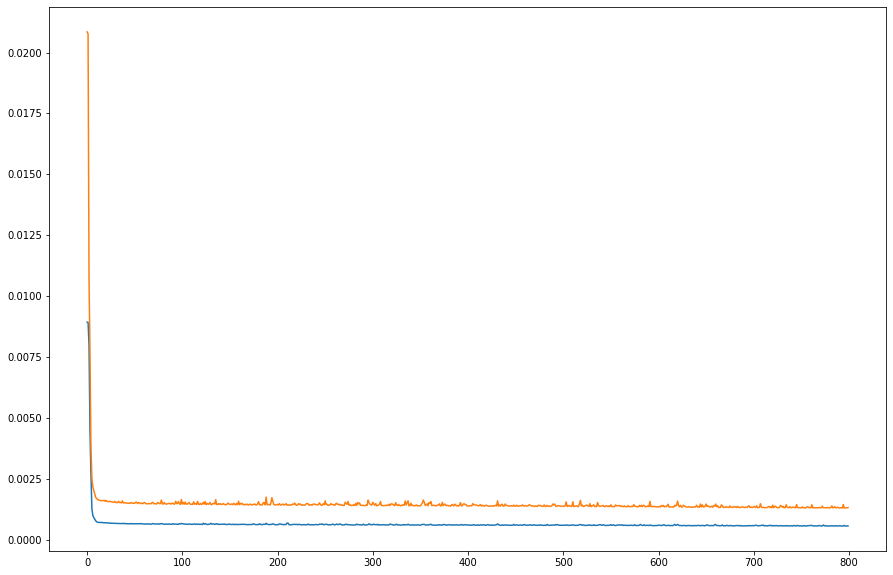

In [ ]:
train_ls = s.training_loss_history
val_ls = s.val_loss_history
plt.plot(range(len(train_ls)), train_ls)
plt.plot(range(len(train_ls)), val_ls)

# Test Performance

In [ ]:
# Old values
# sca_pred_our = s.run_test()
sca_pred_HW = spect_cnn_sc_hw.run_test(s_0)

# mse_our = torch.nn.functional.mse_loss(sca_pred_our, s.test_sca)
mse_hw = torch.nn.functional.mse_loss(sca_pred_HW, s_0.test_sca)
# den = torch.sum()

# print(mse_our)
print(mse_hw)

tensor(0.0072, device='cuda:0')
tensor(0.0026, device='cuda:0')


In [ ]:
# New values
# sca_pred_our = s.run_test()
spect_cnn_sc_hw.load_model('HW_CNN_best_checkpoint.pth')
sca_pred_HW = spect_cnn_sc_hw.run_test(s_0)

# mse_our = torch.nn.functional.mse_loss(sca_pred_our, s.test_sca)
mse_hw = torch.nn.functional.mse_loss(sca_pred_HW, s_0.test_sca)
# den = torch.sum()

# print(mse_our)
print(mse_hw)

tensor(0.0022, device='cuda:0')


In [ ]:
# NRMSE in Projection Domain
err = sca_pred_HW - s_0.test_sca
err_num = torch.sqrt(torch.sum(torch.square(err)))
err_de = torch.sqrt(torch.sum(torch.square(s_0.test_sca)))
print('NRMSE in Projection Domain: ', str((err_num/err_de).item()*100) + '%')

NRMSE in Projection Domain:  3.7006258964538574%


In [ ]:
# Old NRMSE in Projection Domain
err = sca_pred_HW - s_0.test_sca
err_num = torch.sqrt(torch.sum(torch.square(err)))
err_de = torch.sqrt(torch.sum(torch.square(s_0.test_sca)))
print(err_num/err_de)

tensor(0.0415, device='cuda:0')


In [ ]:
sca_pred_np = sca_pred_HW.squeeze().permute(1,2,0).cpu().numpy()
print(sca_pred_np.shape)
pred_mat = sca_pred_np.reshape(128,80,128,s_0.N_test) # Reshape!!!!!!!! Otherwise, the plots are not in order of views
print(pred_mat.shape)

(128, 80, 1792)
(128, 80, 128, 14)


In [ ]:
# if we test the network with the training dataset...
train_file_path2 = os.path.join(GOOGLE_DRIVE_PATH, 'dataset/train/*.mat')
test_file_path2 = os.path.join(GOOGLE_DRIVE_PATH, 'dataset/train/*.mat')

s_n = SPECT_DATASET_NON_UNIF()
s_n.data_preprocess(train_file_path2, test_file_path2)

spect_cnn_sc_hw2 = SPECT_CNN_SC_HW()
spect_cnn_sc_hw2.load_model("HW_CNN_best_checkpoint.pth")

In [ ]:
sca_pred2 = spect_cnn_sc_hw2.run_test(s_n)

err2 = sca_pred2 - s_n.test_sca
err_num2 = torch.sqrt(torch.sum(torch.square(err2)))
err_de2 = torch.sqrt(torch.sum(torch.square(s_n.test_sca)))
print(err_num2/err_de2)

tensor(0.0193, device='cuda:0')


# Test One By One

In [ ]:
train_file_path = os.path.join(GOOGLE_DRIVE_PATH, 'dataset/train/*.csv')
test_file_path = os.path.join(GOOGLE_DRIVE_PATH, 'dataset/test_real_patient_2/*di*')

s_t = SPECT_DATASET_NON_UNIF()
s_t.data_preprocess(train_file_path, test_file_path)

spect_cnn_sc_hw_t = SPECT_CNN_SC_HW()
spect_cnn_sc_hw_t.load_model("HW_CNN_best_checkpoint.pth")
sca_pred = spect_cnn_sc_hw_t.run_test(s_t)
print(sca_pred.shape)

sca_pred_np = sca_pred.squeeze().permute(1,2,0).cpu().numpy()
print(sca_pred_np.shape)

sio.savemat('y90resth8054_pred_sca.mat', {'sca':sca_pred_np}, do_compression=True)

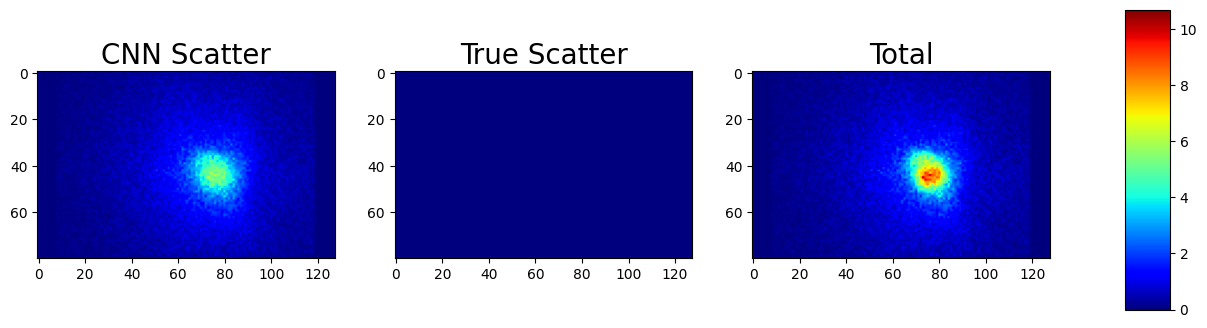

In [ ]:
spect_cnn_sc_hw_t.test_and_plot_k(s_t, 50) # real patient, do not have true scatter